In [1]:
%%writefile kaggle.json
{"username":"xx","key":"xx"}

Writing kaggle.json


In [2]:
!pip install -qq kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -qq cell-images-for-detecting-malaria.zip

kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99% 668M/675M [00:13<00:00, 49.3MB/s]
100% 675M/675M [00:13<00:00, 53.1MB/s]


In [88]:
import glob
import random
from pathlib import Path
from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt

In [5]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [6]:
trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    transforms.RandomAffine(5, translate=(0.01,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [7]:
val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [39]:
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        super(MalariaImages).__init__()
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]
        clss = Path(str(Path(fpath).parent)).name
        img = Image.open(fpath)
        return img, clss

    def choose(self):
        return self[random.randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

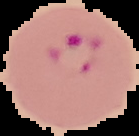

(None, 'Parasitized')

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = glob.glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

# sample data
from google.colab.patches import cv2_imshow
cv2_imshow(trn_ds[0][0]), trn_ds[0][1]

In [78]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [79]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [80]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

train_loss, test_loss = [], []
train_acc, test_acc = [], []
for epoch in tqdm(range(n_epochs), desc="Epochs"):
    epoch_train_loss, epoch_test_loss = 0, 0
    epoch_train_acc, epoch_test_acc = 0, 0

    N = len(trn_dl)
    for idx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        epoch_train_loss += loss; epoch_train_acc += acc
    epoch_train_loss /= N; epoch_train_acc /= N

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        epoch_test_loss += loss; epoch_test_acc += acc
    epoch_test_loss /= N; epoch_test_acc /= N

    train_loss.append(epoch_train_loss); train_acc.append(epoch_train_acc)
    test_loss.append(epoch_test_loss); test_acc.append(epoch_test_acc)

    # Print metrics for the current epoch
    tqdm.write(f"Epoch [{epoch+1}/{n_epochs}], "
               f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
               f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

Epochs:  50%|█████     | 1/2 [02:06<02:06, 126.73s/it]

Epoch [1/2], Train Loss: 0.2402, Train Acc: 0.9113, Test Loss: 0.1576, Test Acc: 0.9522


Epochs: 100%|██████████| 2/2 [04:13<00:00, 126.77s/it]

Epoch [2/2], Train Loss: 0.1692, Train Acc: 0.9452, Test Loss: 0.1798, Test Acc: 0.9402


In [81]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [91]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    # print(activations.shape)
    pred = logits.max(-1)[-1]

    # get the model's prediction
    model.zero_grad()

    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)

    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))

    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]

    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [89]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

def subplots(images, nc=2, figsize=(10, 5), suptitle=None):
    """Display images in subplots."""
    fig, axs = plt.subplots(1, nc, figsize=figsize)
    for ax, img in zip(axs, images):
        ax.imshow(img, aspect='auto')
        ax.axis('off')  # Hide axes
    if suptitle:
        plt.suptitle(suptitle)
    plt.show()

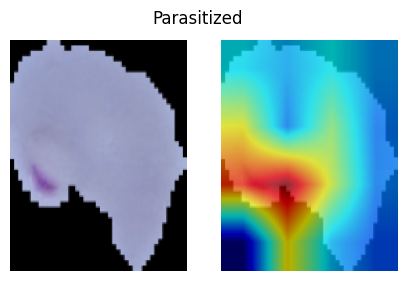

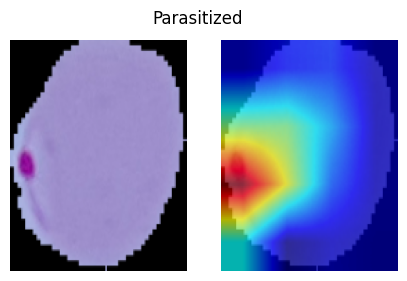

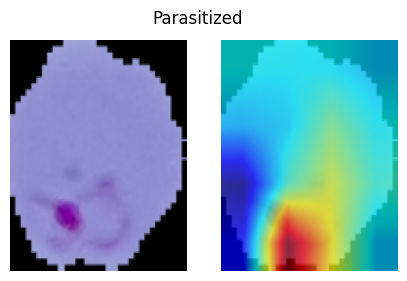

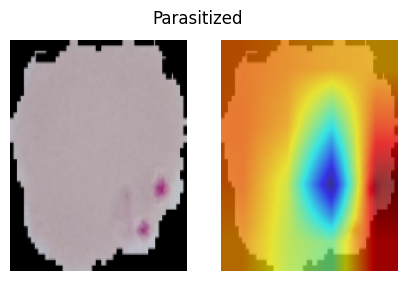

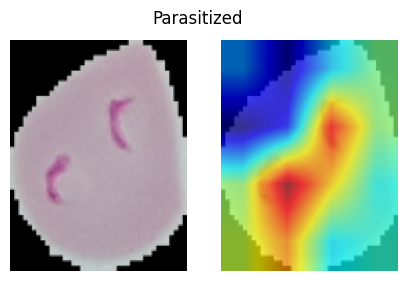

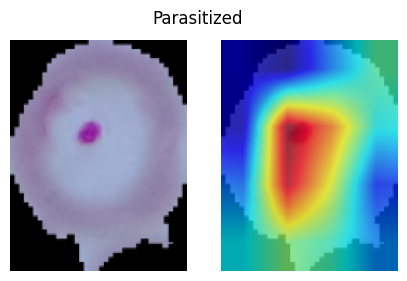

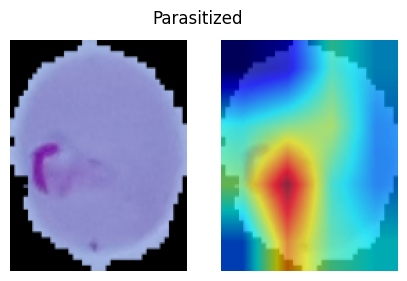

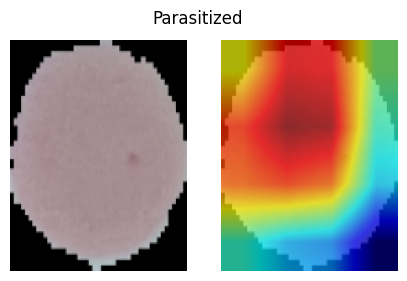

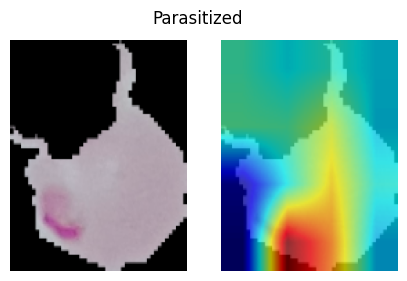

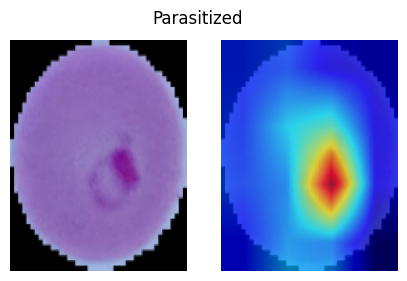

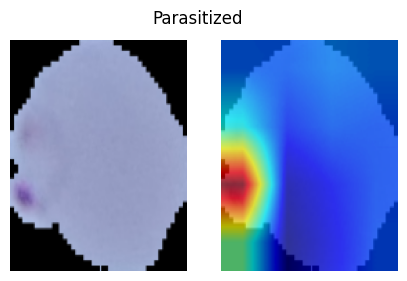

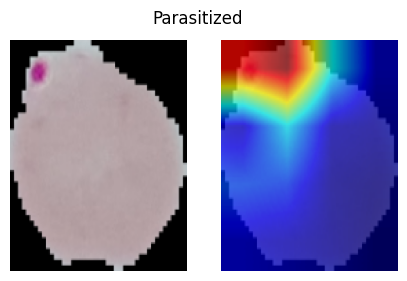

In [92]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = cv2.resize(z[i], (SZ, SZ))
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)